# Single Cell QC

In [1]:
import warnings
warnings.filterwarnings("ignore")
import muon as mu
import numpy as np
import scanpy as sc
import scirpy as ir
from cycler import cycler
from matplotlib import cm as mpl_cm
from matplotlib import pyplot as plt
from mudata import MuData
sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [2]:
sc.logging.print_header()
np.random.seed(42)
import random
random.seed(42)

scanpy==1.10.2 anndata==0.11.3 umap==0.5.6 numpy==1.26.4 scipy==1.11.1 pandas==2.2.3 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


In [3]:
%pwd

'/ihome/ylee/yiz133/Code/Data processing'

In [4]:
%cd /ihome/ylee/yiz133/Code/Scirpy/scripy/data

/ihome/ylee/yiz133/Code/Scirpy/scripy/data


## Importing data from csv

In [5]:
# dates = ["0516_","0605_"]
# tissue = ["CNS", "SPL"]
# adatas_tcr = {}
# adatas_gex = {}
# import anndata

# for D in dates:
#     for T in tissue:
#         sample = D+T 
#         adata_tcr = ir.io.read_10x_vdj(
#             sample + "_filtered_contig_annotations.csv"
#         )
        
#         # Load the associated transcriptomics data
#         adata_gex = sc.read_10x_h5(
#             sample + "_sample_filtered_feature_bc_matrix.h5", gex_only = False
#         )
#         adata_gex.var_names_make_unique()
#         adata_df = adata_gex.to_df()
        
#         df2 = adata_df.filter(regex='CMO')
#         df2['mouse_id'] = df2.idxmax(axis=1)
#         adata_gex.obs["mouse_id"] = df2['mouse_id']

#         adata_gex.obs["date"] = D[:-1]
#         adata_gex.obs["tissue"] = T[:-1]
        
#         adata_gex.obs.index = adata_gex.obs.index + "_" + sample
#         adata_tcr.obs.index = adata_tcr.obs.index + "_" + sample
    
#         adatas_gex[sample] = adata_gex
#         adatas_tcr[sample] = adata_tcr
        
#         print(f"Loaded {sample}: GEX shape {adata_gex.shape}, TCR shape {adata_tcr.shape}")
        
#         adata_gex = anndata.concat(adatas_gex, index_unique=None)  # Merge GEX
#         adata_tcr = anndata.concat(adatas_tcr, index_unique=None)  # Merge TCR

reading 0516_CNS_sample_filtered_feature_bc_matrix.h5
 (0:00:00)
Loaded 0516_CNS: GEX shape (4780, 33708), TCR shape (2637, 0)
reading 0516_SPL_sample_filtered_feature_bc_matrix.h5
 (0:00:05)
Loaded 0516_SPL: GEX shape (34423, 33708), TCR shape (28337, 0)
reading 0605_CNS_sample_filtered_feature_bc_matrix.h5
 (0:00:04)
Loaded 0605_CNS: GEX shape (27799, 33708), TCR shape (15058, 0)
reading 0605_SPL_sample_filtered_feature_bc_matrix.h5
 (0:00:04)
Loaded 0605_SPL: GEX shape (39433, 33708), TCR shape (31628, 0)


# pre-processing

In [6]:
##### load data
# adata_gex.write("all_gex.h5ad")
# adata_tcr.write("all_tcr.h5ad")

adata_gex = sc.read("all_gex.h5ad")
adata_tcr = sc.read("all_tcr.h5ad")

In [7]:
import matplotlib.pyplot as plt
import numpy as np
adata_gex.obs["sample"] = adata_gex.obs.index.to_series().str.rsplit("_", n=2).str[-1] + "_" + adata_gex.obs.index.to_series().str.rsplit("_", n=2).str[-2]
adata_gex.obs["sample"]

AAACCAAAGGGGAGCT-1_0516_CNS    CNS_0516
AAACCAAAGGTCGACT-1_0516_CNS    CNS_0516
AAACCAGCACGTAAAG-1_0516_CNS    CNS_0516
AAACCATTCACTACTC-1_0516_CNS    CNS_0516
AAACCATTCCTCCGGT-1_0516_CNS    CNS_0516
                                 ...   
GTTGTGGGTGGATCGC-1_0605_SPL    SPL_0605
GTTGTGGGTGGCTGTA-1_0605_SPL    SPL_0605
GTTGTGGGTGGTCCCC-1_0605_SPL    SPL_0605
GTTGTGGGTGTCCCTG-1_0605_SPL    SPL_0605
GTTGTGGGTGTTACCC-1_0605_SPL    SPL_0605
Name: sample, Length: 106435, dtype: object

In [8]:
mdata = mu.MuData({"gex": adata_gex, "airr": adata_tcr})

## GEX QC

In [9]:
# mdata = mu.read("0605_mData_allCommon.h5mu")
# mdata

In [10]:
adata = adata_gex

prefixes_to_remove = ('CMO', 'ENSM') 

TCR_gene_mask = adata .var_names.str.startswith(prefixes_to_remove)
adata = adata [:, ~TCR_gene_mask]
adata

View of AnnData object with n_obs × n_vars = 106435 × 32960
    obs: 'mouse_id', 'date', 'tissue', 'sample'

In [12]:
adata = adata_gex
tcr_genes = adata.var_names[adata.var_names.str.startswith(('Tr'))]
tcr_genes

Index(['Tram1', 'Trpa1', 'Tram2', 'Trak2', 'Trip12', 'Trpm8', 'Traf3ip1',
       'Trmt1l', 'Trp53bp2', 'Traf5',
       ...
       'Trpd52l3', 'Trim8', 'Trub1', 'Trex2', 'Trmt2b', 'Trap1a', 'Trpc5',
       'Trpc5os', 'Tro', 'Trappc2'],
      dtype='object', length=488)

In [13]:
tcr_genes = adata.var_names[adata.var_names.str.startswith(('Trav', 'Traj', 'Trac', 'Trbv', 'Trbj', 
                                                            'Trbc', 'Trdv', 'Trdj', 'Trdc', 'Trgv', 'Trgj', 'Trgc'))]
tcr_genes

Index(['Trbv1', 'Trbv2', 'Trbv3', 'Trbv4', 'Trbv5', 'Trbv6', 'Trbv7', 'Trbv8',
       'Trbv9', 'Trbv10',
       ...
       'Traj9', 'Traj8', 'Traj7', 'Traj6', 'Traj5', 'Traj4', 'Traj3', 'Traj2',
       'Traj1', 'Trac'],
      dtype='object', length=266)

In [16]:
tcr_expr = adata[:, tcr_genes].X

# Optional: Convert to dense matrix (if sparse) and print as DataFrame
import numpy as np
import pandas as pd

if not isinstance(tcr_expr, np.ndarray):
    tcr_expr = tcr_expr.toarray()

df_tcr_expr = pd.DataFrame(tcr_expr, columns=tcr_genes, index=adata.obs_names)


In [18]:
# Count non-zero TCR gene expression per cell (i.e., per row)
nonzero_tcr_counts = (df_tcr_expr > 0).sum(axis=1)

# Add to AnnData obs for convenience
adata.obs["tcr_gene_count"] = nonzero_tcr_counts

# Print the first few rows
print(adata.obs[["tcr_gene_count"]].head())


                             tcr_gene_count
AAACCAAAGGGGAGCT-1_0516_CNS               2
AAACCAAAGGTCGACT-1_0516_CNS               0
AAACCAGCACGTAAAG-1_0516_CNS               5
AAACCATTCACTACTC-1_0516_CNS               0
AAACCATTCCTCCGGT-1_0516_CNS               3


In [11]:
adata.var_names_make_unique()

adata.var["mt"] = adata.var_names.str.startswith("mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^Hb[^(p)]")

# unique_values, counts = np.unique(adata.var["hb"], return_counts=True)
# for value, count in zip(unique_values, counts):
#     print(f"{value}: {count}")

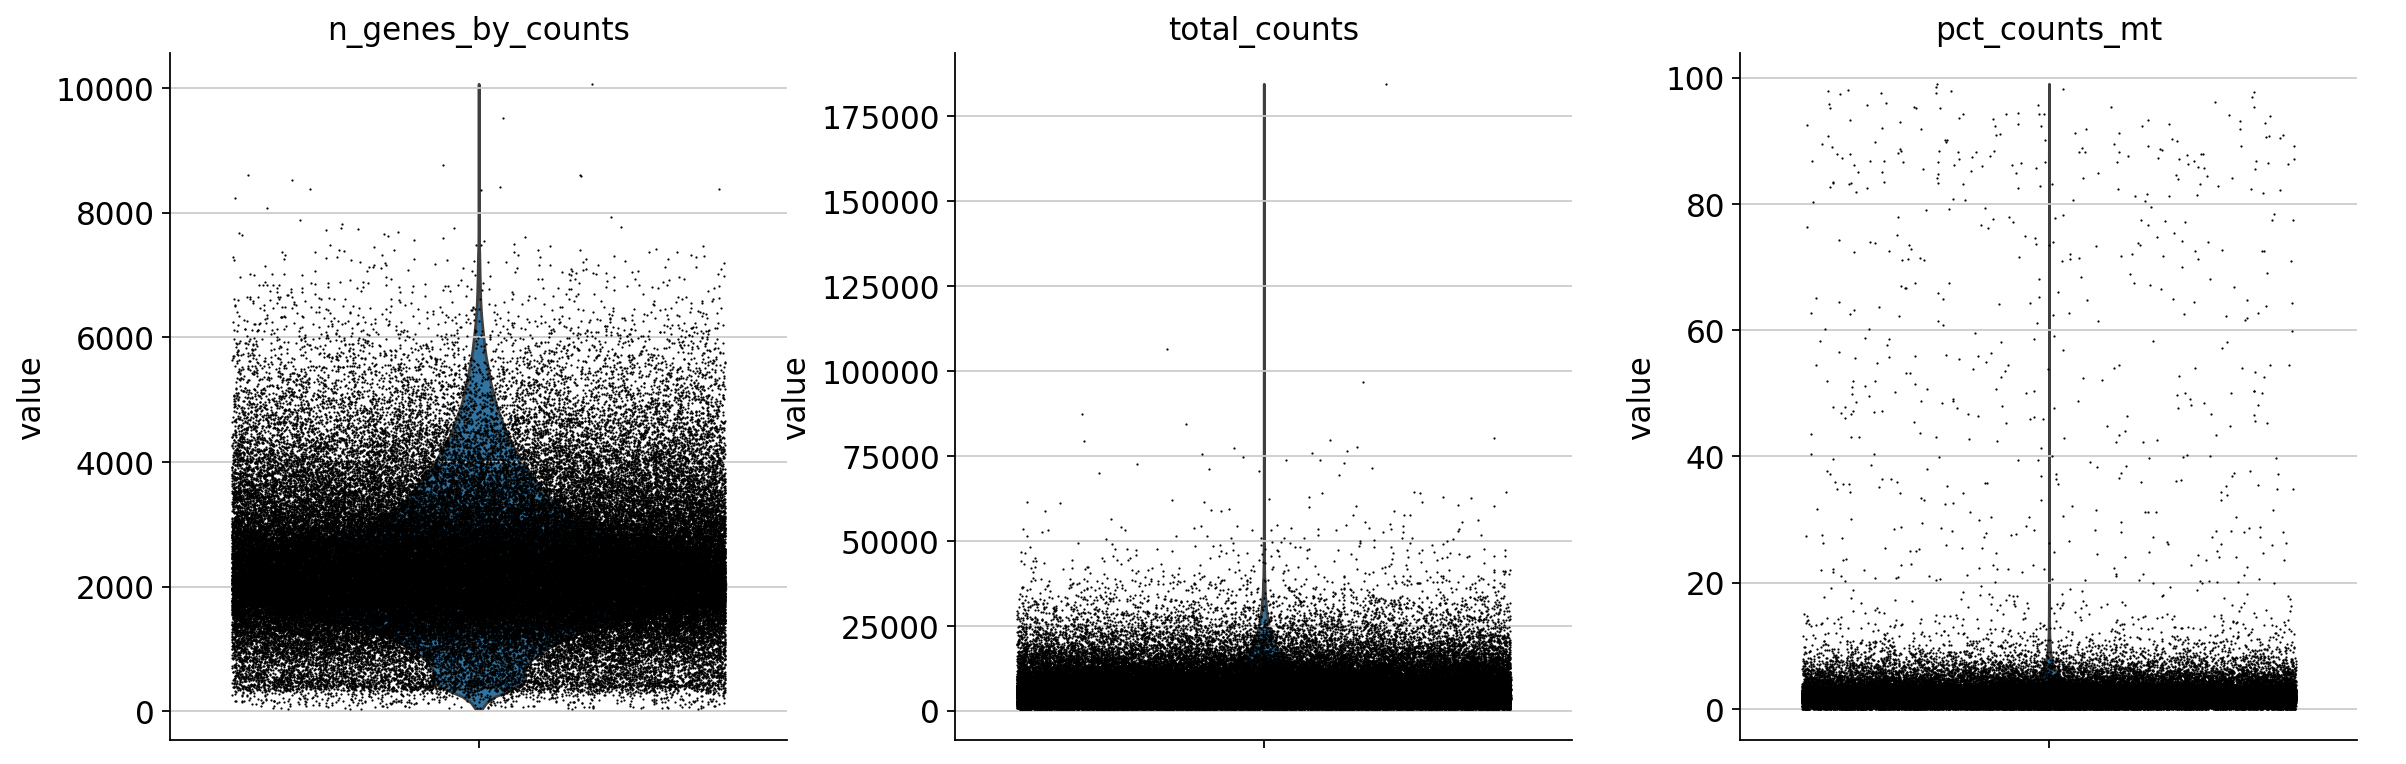

In [12]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [13]:
# adata = adata_gex
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes= 8000)

sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_cells(adata, max_counts=40000)

sc.pp.filter_genes(adata, min_cells=50)
# sc.pp.filter_genes(adata, max_cells=100)

# sc.pp.filter_genes(adata, min_counts=50)
# sc.pp.filter_genes(adata, max_counts=100)

# remove mt- genes
adata = adata[:, ~adata.var_names.str.startswith('mt')].copy()
adata

filtered out 225 cells that have less than 200 genes expressed
filtered out 13 cells that have more than 8000 genes expressed
filtered out 222 cells that have more than 40000 counts
filtered out 14603 genes that are detected in less than 50 cells


AnnData object with n_obs × n_vars = 105975 × 18344
    obs: 'mouse_id', 'date', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [14]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:01)


extracting highly variable genes
    finished (0:00:12)


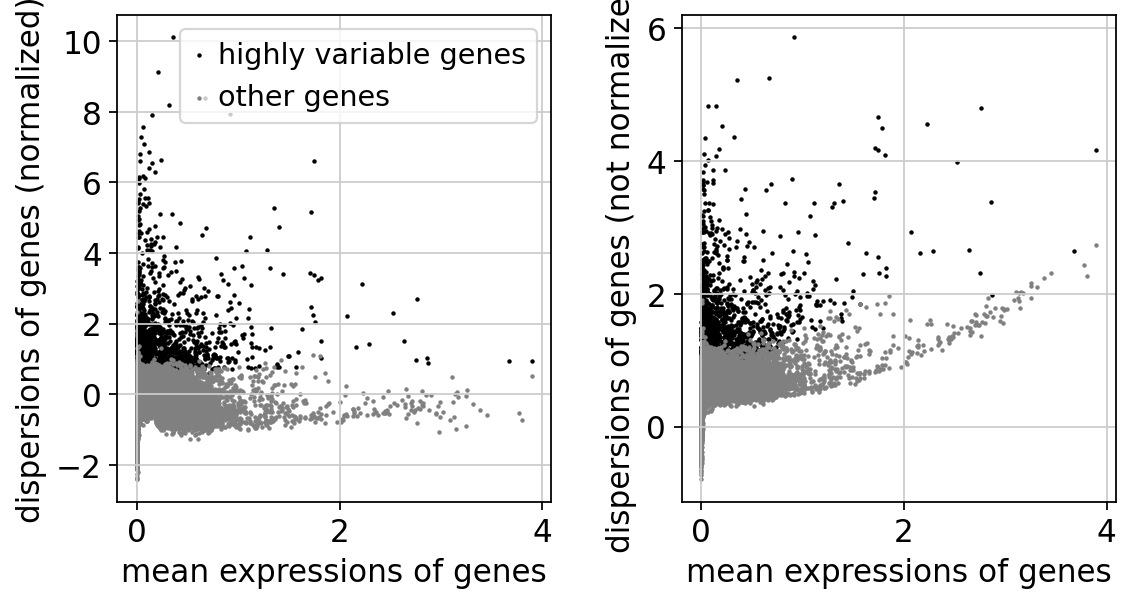

In [15]:
# sc.pp.scrublet(adata, batch_key="sample")
# have little effect

sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
sc.pl.highly_variable_genes(adata)

adata = adata[:, adata.var['highly_variable']].copy()

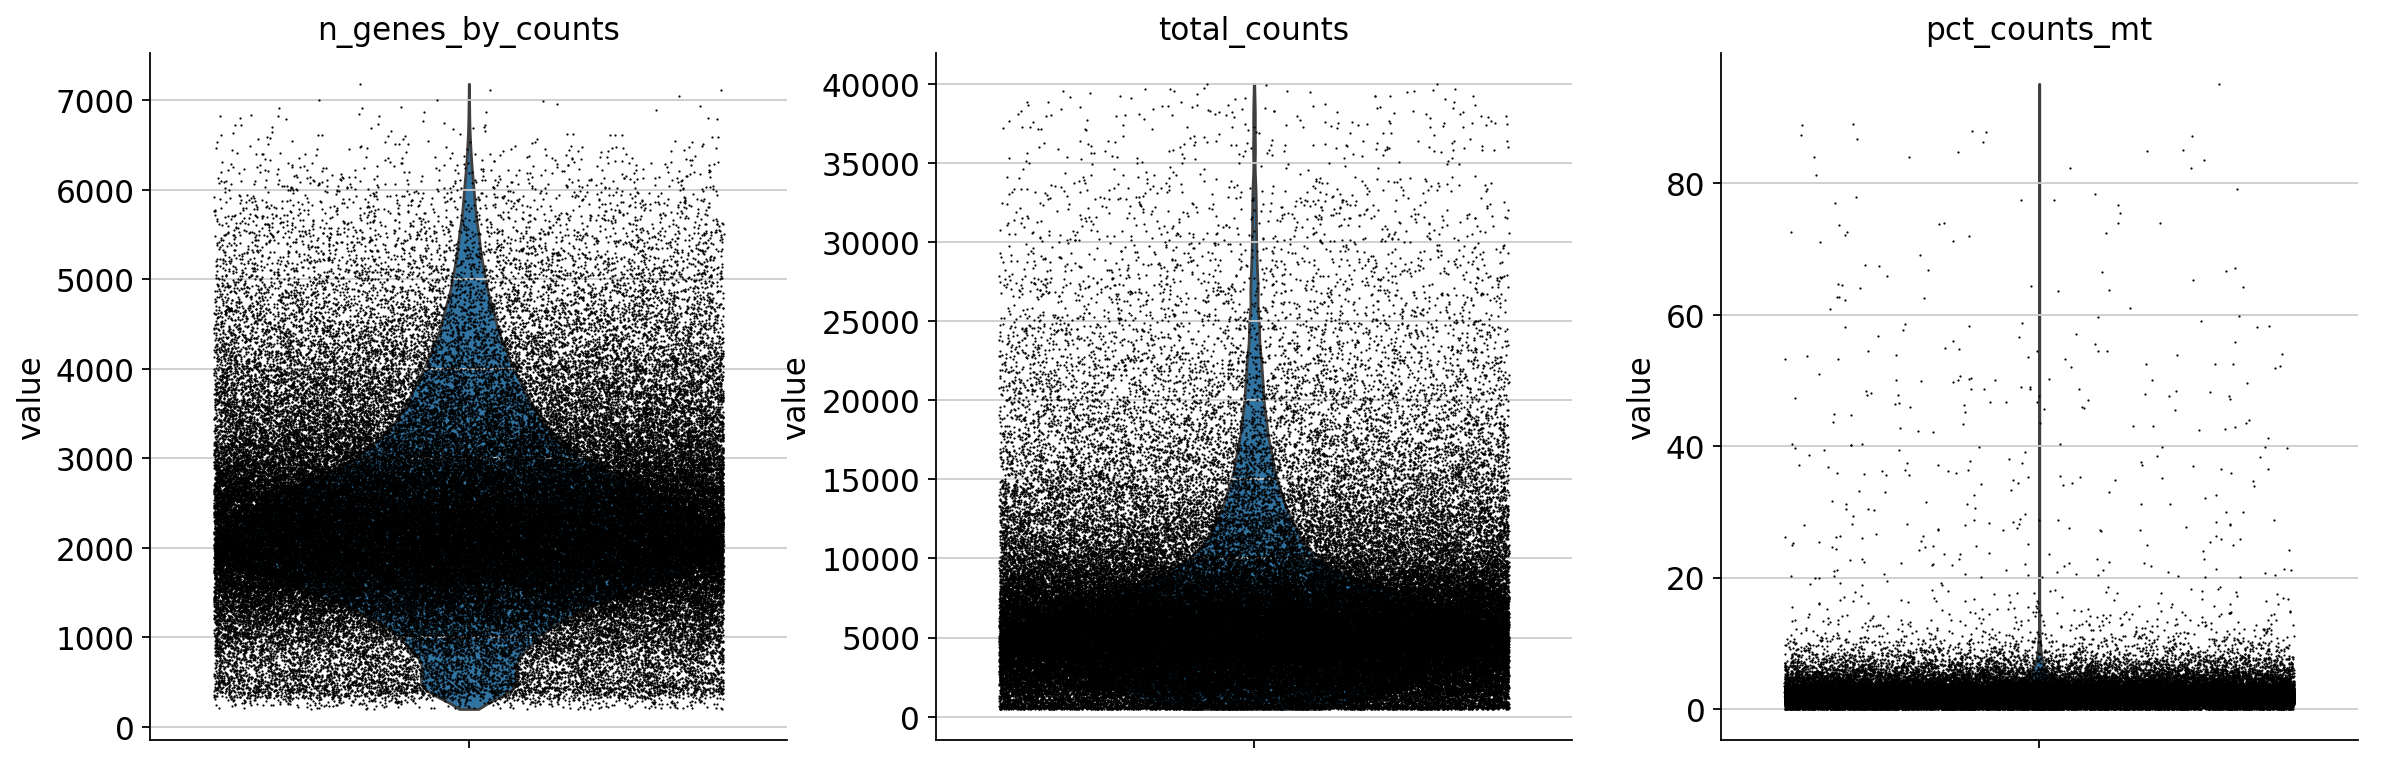

In [16]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


In [17]:
mdata = mu.MuData({"gex": adata, "airr": adata_tcr})

## load cell types metadata

In [18]:
import pandas as pd
metadata_paths = {
    "CNS": "CNS_cell_type_annotation.csv",
    "SPL": "Spleen_cell_type_annotation.csv"
}

# Read metadata files
metadata_list = []
for tissue, path in metadata_paths.items():
    meta = pd.read_csv(path, index_col=0)  # Ensure the first column is treated as the index

    # Extract run number from the index (barcode) → `_1` means "0516", `_2` means "0605"
    meta["run_num"] = meta.index.to_series().str.split("_").str[-1].map({"1": "0516", "2": "0605"})

    # Create the correct barcode format: "AAACCAAAGGGGAGCT-1_CNS_0605"
    meta["barcode"] = meta.index.to_series().str.replace("_1", "", regex=False).str.replace("_2", "", regex=False)
    meta["barcode"] = meta["barcode"] + "_" + meta["run_num"] + "_" + tissue

    metadata_list.append(meta)

# Combine metadata from both CNS and Spleen
metadata = pd.concat(metadata_list, ignore_index=False)  # Keep original index

# Merge metadata with `mdata.obs`
mdata.obs = mdata.obs.merge(metadata, left_index=True, right_on="barcode", how="left")

# Set the index to the barcode column for consistency
mdata.obs.set_index("barcode", inplace=True)
mdata

MuData object with n_obs × n_vars = 106076 × 2000
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num'
  2 modalities
    gex:	105975 x 2000
      obs:	'mouse_id', 'date', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'log1p', 'hvg'
    airr:	77660 x 0
      obsm:	'airr'

### Get common cell indices between gex and airr

In [19]:
# Count non-NA rows by sample
mdata.obs["sample"] = adata_gex.obs["sample"]
non_na_counts = mdata.obs.dropna().groupby("sample").size()
non_na_counts.sum()

79747

In [20]:
idx1 = mdata.mod["airr"].obs.index
idx2 = mdata.mod["gex"].obs.index
common_cells = idx1.intersection(idx2)

# Subset gex to only include these cells
gex_subset = mdata.mod["gex"][common_cells, :].copy()
tcr_subset = mdata.mod["airr"][common_cells, :].copy()
# Create a new MuData object to preserve alignment

mdata_common = mu.MuData({"gex": gex_subset, "airr": tcr_subset})

# Copy previous metadata from the old mdata object
mdata_common.obs = mdata.obs.loc[mdata_common.mod["gex"].obs.index]
mdata = mdata_common
mdata

MuData object with n_obs × n_vars = 77559 × 2000
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample'
  2 modalities
    gex:	77559 x 2000
      obs:	'mouse_id', 'date', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'log1p', 'hvg'
    airr:	77559 x 0
      obsm:	'airr'

In [21]:
mdata.write("0605_all_Common_DEtop2000.h5mu")

In [22]:
# what can be used as 'color'
print(mdata.var_names)

Index(['Xkr4', 'St18', 'Prex2', 'Sulf1', 'Slco5a1', 'Il17a', 'Il17f', 'Gm4956',
       'Kcnq5', 'Ogfrl1',
       ...
       'Ptchd1', 'Phex', 'Cnksr2', 'Bmx', 'Pir', 'Gpm6b', 'Tlr8', 'Frmpd4',
       'Arhgap6', 'Gm47283'],
      dtype='object', length=2000)


## Filter data regarding the sample 

In [55]:
# exclude 2D2 transfer samples.
mdata = mu.read("0605_all_Common_DEtop2000.h5mu")

selected_samples_id = ["CMO301", "CMO302", "CMO318", "CMO325", "CMO323"]
selected_date = ["0516"]
selected_tissue = ["CN"]

# only keep 0605 spleen
mdata = mdata[~ mdata.mod["gex"].obs["date"].isin(selected_date)]

mdata = mdata[mdata.mod["gex"].obs["tissue"].isin(["CN"]) ]

mdata

View of MuData object with n_obs × n_vars = 15029 × 2000
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample'
  2 modalities
    gex:	15029 x 2000
      obs:	'mouse_id', 'date', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'hvg', 'log1p'
    airr:	15029 x 0
      obsm:	'airr'

In [61]:
# mdata.write("0605_CNS_DE_top2000.h5mu")

In [57]:
sc.pp.pca(mdata["gex"], svd_solver="arpack", n_comps=20)
mdata1 = mdata.copy()
mdata2 = mdata.copy()

computing PCA
    with n_comps=20
    finished (0:00:02)


computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:03)
computing UMAP
    finished (0:00:21)
running Leiden clustering
    finished (0:00:00)


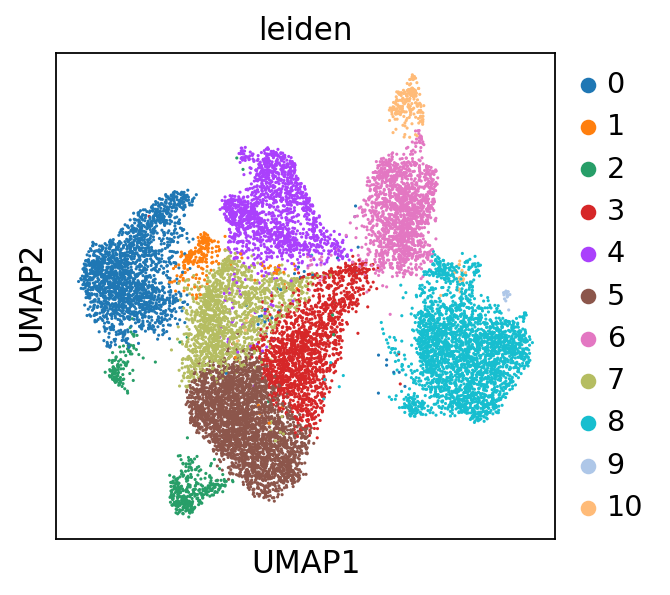

In [58]:
sc.pp.neighbors(mdata1["gex"], n_neighbors = 20)
sc.tl.umap(mdata1["gex"], min_dist=0.5, spread=1.0)
sc.tl.leiden(mdata1["gex"], resolution = 0.5, n_iterations=2, flavor = 'igraph')
sc.pl.umap(mdata1["gex"], color=["leiden"])


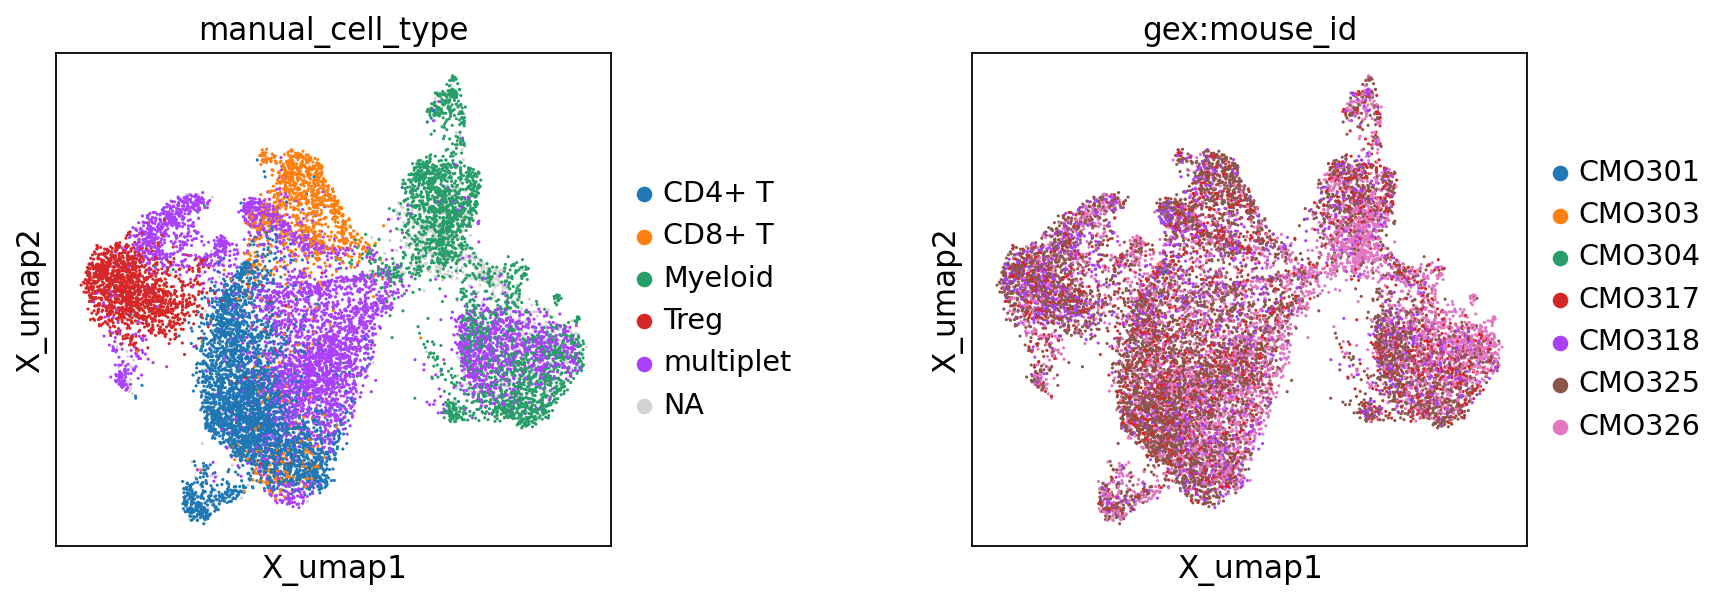

In [59]:
mu.pl.embedding(mdata1, basis="gex:umap", color=['manual_cell_type', 'gex:mouse_id'], wspace = 0.5)

In [60]:
mdata1['gex'].obs["leiden"].nunique()
aaa

NameError: name 'aaa' is not defined

In [ ]:
# List of clonotypes to analyze
leiden_clusters = [str(i) for i in range(mdata1['gex'].obs["leiden"].nunique())]

sc.tl.rank_genes_groups(
    mdata1["gex"],
    "leiden",
    groups = leiden_clusters,
    reference= "rest",
    method="wilcoxon"
)

# top_gene_list=tmp_ad.uns['rank_genes_groups']['names']

# Dynamically determine the number of rows/columns for subplots
num_clonotypes = len(leiden_clusters)
num_cols = 2  # Number of columns in the figure
num_rows = int(np.ceil(num_clonotypes / num_cols))  # Number of rows based on total clonotypes

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))  
axs = axs.flatten()  # Flatten in case of multiple rows

# Generate violin plots for each clonotype
for ct, ax in zip(leiden_clusters, axs):
    sc.pl.rank_genes_groups_violin(mdata1["gex"], groups=[ct], n_genes=10, ax=ax, show=False, strip=False)

# Remove any unused subplots
for i in range(len(leiden_clusters), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
a1 = mdata1["gex"].uns['rank_genes_groups']['names'][0:10].tolist()
com_genes1 = pd.DataFrame(a1)
com_genes1

## clusters-2

In [ ]:
sc.pp.neighbors(mdata2["gex"], n_neighbors = 50)
sc.tl.umap(mdata2["gex"], min_dist=0.5, spread= 5.0)
sc.tl.leiden(mdata2["gex"], resolution = 0.2, n_iterations=-1, flavor = 'igraph')
sc.pl.umap(mdata2["gex"], color=["leiden"])

In [ ]:
# List of clonotypes to analyze
leiden_clusters = [str(i) for i in range(mdata2['gex'].obs["leiden"].nunique())]

sc.tl.rank_genes_groups(
    mdata2["gex"],
    "leiden",
    groups = leiden_clusters,
    reference= "rest",
    method="wilcoxon"
)

# top_gene_list=tmp_ad.uns['rank_genes_groups']['names']

# Dynamically determine the number of rows/columns for subplots
num_clonotypes = len(leiden_clusters)
num_cols = 2  # Number of columns in the figure
num_rows = int(np.ceil(num_clonotypes / num_cols))  # Number of rows based on total clonotypes

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))  
axs = axs.flatten()  # Flatten in case of multiple rows

# Generate violin plots for each clonotype
for ct, ax in zip(leiden_clusters, axs):
    sc.pl.rank_genes_groups_violin(mdata2["gex"], groups=[ct], n_genes=10, ax=ax, show=False, strip=False)

# Remove any unused subplots
for i in range(len(leiden_clusters), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

In [ ]:
# not use L/R (CD), TF are best

In [ ]:
import pandas as pd
a = mdata2["gex"].uns['rank_genes_groups']['names'][0:20].tolist()
com_genes2 = pd.DataFrame(a)
com_genes2

# 0---0  1---1  (5---2)   2---3   6---4  7---5
# 4 lost 

In [ ]:
cluster_2_type = {"0":"CD4+" , "1": "CD8+", "2":"T reg", "3":"CD8+", "4":}

# DEA among annotated cell types

In [ ]:
cell_types = ['CD4+ T', 'CD8+ T', 'Treg']
mdata["gex"].obs['manual_cell_type'] = mdata.obs['manual_cell_type']

sc.tl.rank_genes_groups(
        mdata["gex"],
        "manual_cell_type",
        groups = cell_types,
        reference= "rest",
        method="wilcoxon"
    )


In [ ]:
num_plots = len(cell_types)
num_cols = 2  # Number of columns in the figure
num_rows = int(np.ceil(num_plots / num_cols))  # Number of rows based on total clonotypes

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 4))  
axs = axs.flatten()  # Flatten in case of multiple rows

# Generate violin plots for each clonotype
for ct, ax in zip(cell_types, axs):
    sc.pl.rank_genes_groups_violin(mdata["gex"], groups=[ct], n_genes=25, ax=ax, show=False, strip=False)

# Remove any unused subplots
for i in range(len(cell_types), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()
    

In [ ]:
top_gene_by_type = mdata["gex"].uns['rank_genes_groups']['names'][0:20].tolist()
com_genes = pd.DataFrame(top_gene_by_type)
com_genes

In [ ]:
# ir.pp.index_chains(mdata)
# ir.tl.chain_qc(mdata)

In [ ]:
mu.pl.embedding(mdata, basis="gex:umap", color=['manual_cell_type','gex:tissue'], wspace = 0.5)

In [ ]:
# check if markers are still in the data
markers = ['Cd8a', 'cd8b', 'Cd4', 'Cd28', 'Cxcr3', 'Cd25', 'Cd27', 'Il2']
in_anndata = []
for i in markers:
    in_anndata.append( i in mdata["gex"].var_names)
    
in_anndata     

In [ ]:
# mu.pl.embedding(mdata, basis="gex:umap", color=['Cd4'], wspace = 0.5, ncols=2)

In [ ]:
# markers for CD4+
top_gene_Cd4 = com_genes.iloc[:4,0]
mu.pl.embedding(mdata, basis="gex:umap", color= top_gene_Cd4, wspace = 0.5, ncols=2)

In [ ]:
top_gene_Cd8 = com_genes.iloc[:4,1]
mu.pl.embedding(mdata, basis="gex:umap", color=top_gene_Cd8, wspace = 0.5, ncols=2)

In [ ]:
top_gene_Cd8 = com_genes.iloc[:2,2]
mu.pl.embedding(mdata, basis="gex:umap", color=top_gene_Cd8, wspace = 0.5, ncols=2)

In [ ]:
aaa

In [ ]:
# another ploting commd
# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.5})
# mu.pl.embedding(mdata, basis="gex:umap", color=["Cd3e"], ax=ax0, show=False)
# mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_type"], ax=ax1)

# batch effect


In [ ]:
mdata_ori = mu.read("common_GEX_TCR_QC_mdata.h5mu")
mdata_ori

In [ ]:
# exclude 2D2 transfer samples

selected_samples_id = ["CMO301", "CMO302", "CMO318", "CMO325", "CMO323"]
selected_date = ["0516"]
selected_tissue = ["CN"]

mdata = mdata_ori[~ (mdata_ori.mod["gex"].obs["mouse_id"].isin(selected_samples_id) & mdata_ori.mod["gex"].obs["date"].isin(selected_date))]

# positive select
# mdata = mdata[mdata.mod["gex"].obs["sample"].isin(["SPL_0605"]) ]
mdata

In [ ]:
# mdata.obs["sample"] = mdata.obs["sample"].cat.remove_unused_categories()
# mdata.obs["manual_cell_type"] = mdata.obs["manual_cell_type"].cat.remove_unused_categories()
# mdata.obs["celltype_sample"] = (
#     mdata.obs["manual_cell_type"].astype(str) + "_" + mdata.obs["sample"].astype(str)
# )

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(8,8))
# mu.pl.embedding(mdata_ori, basis="gex:umap", ax=ax0)

mask = mdata_ori['gex'].obs['tissue'] == 'SP'

mu.pl.embedding(mdata_ori, basis="gex:umap", color=['gex:mouse_id'], mask_obs=mask, ax=ax0)

In [ ]:
mdata["gex"].obs["mouse_id"].value_counts()

In [ ]:
import bbknn
bbknn.bbknn(mdata["gex"], batch_key="mouse_id", use_annoy=False)

In [ ]:
sc.tl.umap(mdata["gex"])

In [ ]:
mu.pl.embedding(mdata, basis="gex:X_umap", color = ["gex:mouse_id", "manual_cell_type"], wspace = 0.5)


In [ ]:
# alternative plot commmand


# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"wspace": 1})
# sc.pl.umap(mdata["gex"], color=["mouse_id"])
# mdata["gex"].obs["manual_cell_type"] = mdata.obs["manual_cell_type"]

# sc.pl.umap(mdata["gex"], color=["manual_cell_type"])
eee


In [ ]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(mdata["gex"], resolution = 0.5, n_iterations=2, flavor = 'igraph')
sc.pl.umap(mdata["gex"], color=["leiden"])

In [ ]:
mdata["gex"].obs["leiden"]

# Save Filtered TCR table

In [ ]:
mdata = mu.read("common_GEX_TCR_mdata.h5mu")
mdata

In [ ]:
adata_tcr = mdata.mod['airr']
adata_tcr.obsm["airr"][0]

In [ ]:
meta_DF = ir.get.airr(adata_tcr, ["cdr3_aa", "consensus_count", "v_call", "j_call"] ,  ('VJ_1', 'VDJ_1'))

# , "high_confidence","productive"

# ('VJ_1', 'VDJ_1', 'VJ_2', 'VDJ_2'), 

meta_DF.iloc[0:10,:]

In [ ]:
meta_DF["VDJ_1_j_call"].value_counts()

In [ ]:
# meta_DF.to_csv('primary_TCR.csv', index=True)